In [1]:
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt 
# numpy (math) libary
import numpy as np

from os import walk

path1 = '../../../data/'

# torch library and sublibraries
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
f = [] # empty list of files
for (dirpath, dirnames, filenames) in walk(path1):
    f.extend(filenames)

# sort list alphabetically
f.sort()
# remove non .ssv files from list
f = [x for x in f if x[-4:]==".ssv"]

In [3]:
print(f[0])

temp = np.loadtxt(path1+f[0])
data = {}

data['x'] = np.copy(temp)[:,3:-1]
y = np.zeros((temp.shape[0], 11))
for jj in range(temp.shape[0]):
    y[jj, int(temp[jj,-1])] += 1
data['y'] = np.copy(y)
del y

print('input data x has shape: ',  data['x'].shape)
print('output data y has shape: ', data['y'].shape)
print()

if 0:
    jj = 6
    print(data['x'][jj,:])
    print(data['y'][jj,:])
    print(temp[jj,-1])

full_speach_data.ssv
input data x has shape:  (990, 10)
output data y has shape:  (990, 11)



In [4]:
# normalize data in the range [0,1]
for jj in range(data['x'].shape[1]):
    data['x'][:,jj] = (data['x'][:,jj]-min(data['x'][:,jj]))/max(data['x'][:,jj])

In [5]:
# divide training and test sets
train = {}
test = {}

# The problem is to train the network as well as possible using only
# on data from "speakers" 0-47, and then to test the network on
# speakers 48-89, reporting the number of correct classifications
# in the test set.

# setting '0'
default    = [48*11, 42*11]
# setting '1'
nondefault = [45*11, 45*11]

setting = 0
if setting == 0:
    train['x'] = np.copy(data['x'][:default[0],:])
    train['y'] = np.copy(data['y'][:default[0],:])
    
    test['x']  = np.copy(data['x'][-default[1]:,:])
    test['y']  = np.copy(data['y'][-default[1]:,:])
#elif setting == 1:
#    train['x'] = np.copy(data['x'][:nondefault[0],:])
#    train['y'] = np.copy(data['y'][:nondefault[0],:])
#    
#    test['x']  = np.copy(data['x'][-nondefault[1]:,:])
#    test['y']  = np.copy(data['y'][-nondefault[1]:,:])
    
print(train['x'].shape)
print(train['y'].shape)
print()
print(test['x'].shape)
print(test['y'].shape)

(528, 10)
(528, 11)

(462, 10)
(462, 11)


In [6]:
# create x & y torch Variables
x = Variable( torch.from_numpy(train['x']).float() )
y = Variable( torch.from_numpy(train['y']).float() )
# either input data is float or model becomes doublefloat
# https://stackoverflow.com/questions/44717100/pytorch-convert-floattensor-into-doubletensor?rq=1
# create 
x_test = Variable( torch.from_numpy(test['x']).float() )
y_test = Variable( torch.from_numpy(test['y']).float() )

In [7]:
# define settings for plots
def show_graph(string):
    fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
    ax1 = fig.add_subplot(111)

    if string=='loglog':
        for ii, ee in err.items():
            ax1.loglog(ee[2][:], label='error %s, lr=%1.0e'%(ee[0],ee[1]))
    elif string=='logy':
        for ii, ee in err.items():
            ax1.semilogy(ee[2][:], label='error %s, lr=%1.0e'%(ee[0],ee[1]))
    elif string=='logx':
        for ii, ee in err.items():
            ax1.semilogy(ee[2][:], label='error %s, lr=%1.0e'%(ee[0],ee[1]))
    else:
        for ii, ee in err.items():
            ax1.plot(ee[2][:], label='error %s, lr=%1.0e'%(ee[0],ee[1]))

    ax1.set_xlabel('iteration number', fontsize = 16)
    ax1.set_ylabel('loss', fontsize = 16)
    title_string = '%d epochs, batch size %d; [%d, %d, %d] are input, hidden, and output dimensions'%(epochs,N,D_in,H,D_out)
    ax1.set_title(title_string, fontsize = 16)
    legend = ax1.legend(loc='best', fontsize=16)

    plt.show()
    plt.close()

# prints errors in semi-log axis
show_type = 'logy'

# some colors
colors = (('xkcd:orange', 'xkcd:red'),#
          ('xkcd:blue', 'xkcd:purple'),#
          ('xkcd:green', 'xkcd:lime'),#
         )

In [8]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N     = train['x'].shape[0]
D_in  = train['x'].shape[1]
H     = 64
D_out = train['y'].shape[1]

epochs = int(4e3)

In [9]:
# model settings
base_lr = 1e-4
sigm_lr = 1e-6
best_lr = 1.5e-5

# (re-)initialize data dictionary
#mdl = [] # as in model
err = {} # as in error

In [10]:
# define baseline network with relu (clamp)
class Baseline(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(Baseline, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linearOut = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        # sum (linear1) and then relu (clamp)
        h1     = self.linear1(x).clamp(min=0)
        # sum (linear2) and then relu (clamp)
        h2     = self.linear2(h1).clamp(min=0)
        # sum (out) and the output
        y_pred = self.linearOut(h2)
        return y_pred # output = y_pred(icted)

# Construct our model by instantiating the class defined above
basemodel = Baseline(D_in, H, D_out)

# initialize dictionary item
err[0] = ('relu',base_lr,[])

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(basemodel.parameters(), lr=err[0][1])

for t in range(epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = basemodel(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    err[0][2].append(loss.data[0])
    if (t+1)%(epochs//20) == 0:
        print(t+1, loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
del criterion, optimizer

200 371.9397277832031
400 326.59417724609375
600 289.8413391113281
800 260.9612731933594
1000 231.4415283203125
1200 205.39730834960938
1400 185.18948364257812
1600 165.80532836914062
1800 148.36968994140625
2000 133.90530395507812
2200 132.40357971191406
2400 113.70541381835938
2600 109.5915298461914
2800 100.42150115966797
3000 87.82145690917969
3200 84.27388000488281
3400 74.5616455078125
3600 72.38821411132812
3800 66.24182891845703
4000 67.51101684570312


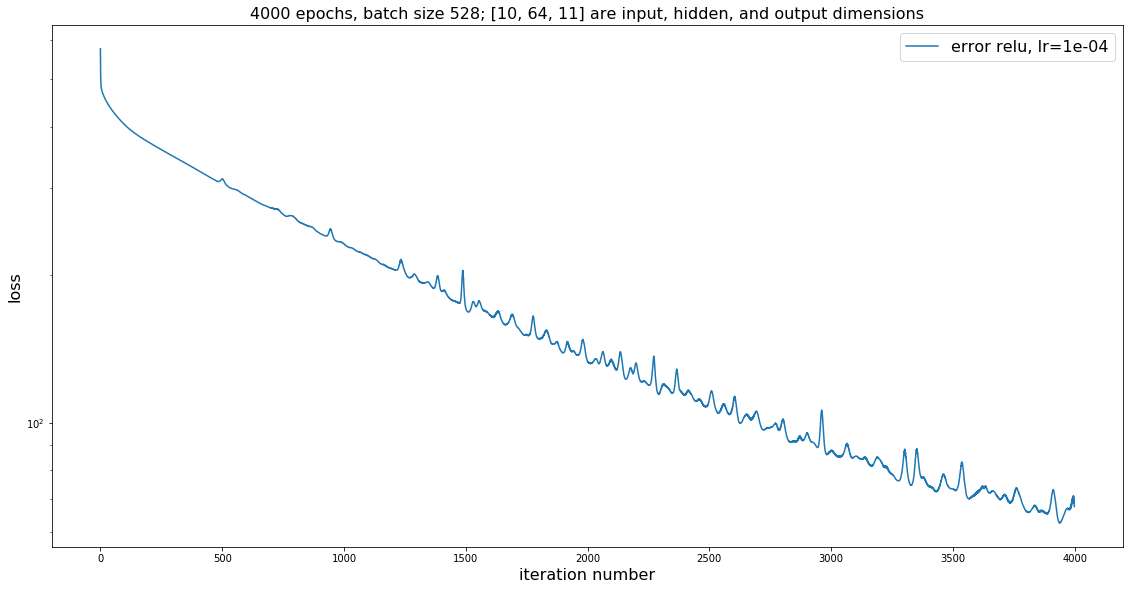

In [11]:
show_graph(show_type)

In [12]:
# define different network with sigmoid
class BaseSigmoid(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(BaseSigmoid, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linearOut = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        # sum (linear1) and then sigmoid (F.sigmoid)
        h1     = F.sigmoid(self.linear1(x))
        # sum (linear2) and then sigmoid (F.sigmoid)
        h2     = F.sigmoid(self.linear2(h1))
        # sum (out) and the output
        y_pred = self.linearOut(h2)
        return y_pred # output = y_pred(icted)

# Construct our model by instantiating the class defined above
sigmodel = BaseSigmoid(D_in, H, D_out)

# initialize dictionary item
err[1] = ('sigmoid',sigm_lr,[])

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(sigmodel.parameters(), lr=err[1][1])

for t in range(epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = sigmodel(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    err[1][2].append(loss.data[0])
    if (t+1)%(epochs//20) == 0:
        print(t+1, loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
del criterion, optimizer

200 480.0990295410156
400 479.8983459472656
600 479.84100341796875
800 479.78350830078125
1000 479.7266540527344
1200 479.6694030761719
1400 479.61151123046875
1600 479.5535583496094
1800 479.4969177246094
2000 479.43988037109375
2200 479.3824768066406
2400 479.3260192871094
2600 479.2686767578125
2800 479.2114562988281
3000 479.154541015625
3200 479.09698486328125
3400 479.0412902832031
3600 478.9847106933594
3800 478.9270935058594
4000 478.8706970214844


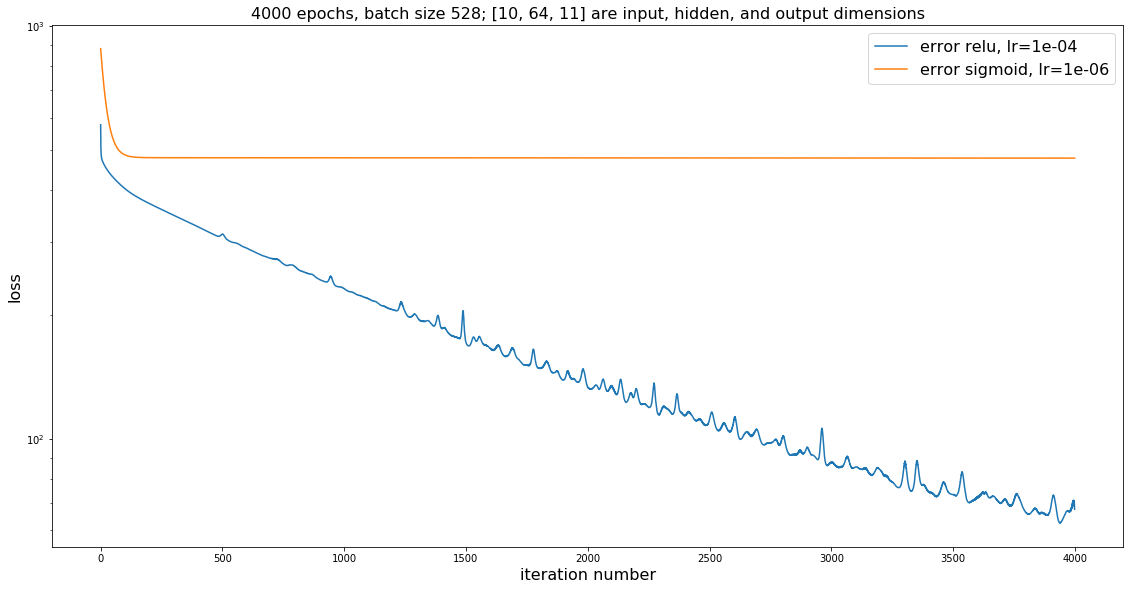

In [13]:
show_graph(show_type)

In [14]:
class BestSigmoid(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(BestSigmoid, self).__init__()
        self.linear1   = torch.nn.Linear(D_in, H)
        self.linear2   = torch.nn.Linear(H, H)
        self.linearOut = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        # parameters
        p = [ 689.651615, 0.433819208, 1.31042204, -0.975437185, -0.518489780, 0.403015568, 0.502495627]
        
        #p[0], p[1], p[2], p[3], p[4], p[5], p[6]
        #  a,    b,    c,    d,    g,   x0,   x1)
        #b*sigmoid(a*(arg-x0))+c*relu(arg)+d*relu(arg-x0)+g*relu(arg-x1)
        
        h1 = torch.mul( torch.sigmoid( self.linear1(x).add_(-p[5]).mul_(p[0]) ), p[1] )
        h1.add_( self.linear1(x).clamp(min=0).mul_(p[2]) )
        h1.add_( self.linear1(x).clamp(min=p[5]).mul_(p[3]) )
        h1.add_( self.linear1(x).clamp(min=p[6]).mul_(p[4]) )
        
        h2 = torch.mul( torch.sigmoid( self.linear2(h1).add_(-p[5]).mul_(p[0]) ), p[1] )
        h2.add_( self.linear2(h1).clamp(min=0).mul_(p[2]) )
        h2.add_( self.linear2(h1).clamp(min=p[5]).mul_(p[3]) )
        h2.add_( self.linear2(h1).clamp(min=p[6]).mul_(p[4]) )
        
        # sum (out) and the output
        y_pred = self.linearOut(h2)
                                
        return y_pred # output = y_pred(icted)

# Construct our model by instantiating the class defined above
bestmodel = BestSigmoid(D_in, H, D_out)

# initialize dictionary item
err[2] = ('bestfit',best_lr,[])

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(bestmodel.parameters(), lr=err[2][1])

for t in range(epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = bestmodel(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    err[2][2].append(loss.data[0])
    if (t+1)%(epochs//20) == 0:
        print(t+1, loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
del criterion, optimizer

200 361.1124267578125
400 318.9252014160156
600 290.5079040527344
800 265.55419921875
1000 246.86669921875
1200 232.51708984375
1400 210.7168731689453
1600 198.6631622314453
1800 197.61734008789062
2000 168.35916137695312
2200 157.8304901123047
2400 159.43853759765625
2600 153.50631713867188
2800 148.57693481445312
3000 132.7859344482422
3200 120.04576873779297
3400 119.34563446044922
3600 114.03484344482422
3800 104.48458099365234
4000 100.01371002197266


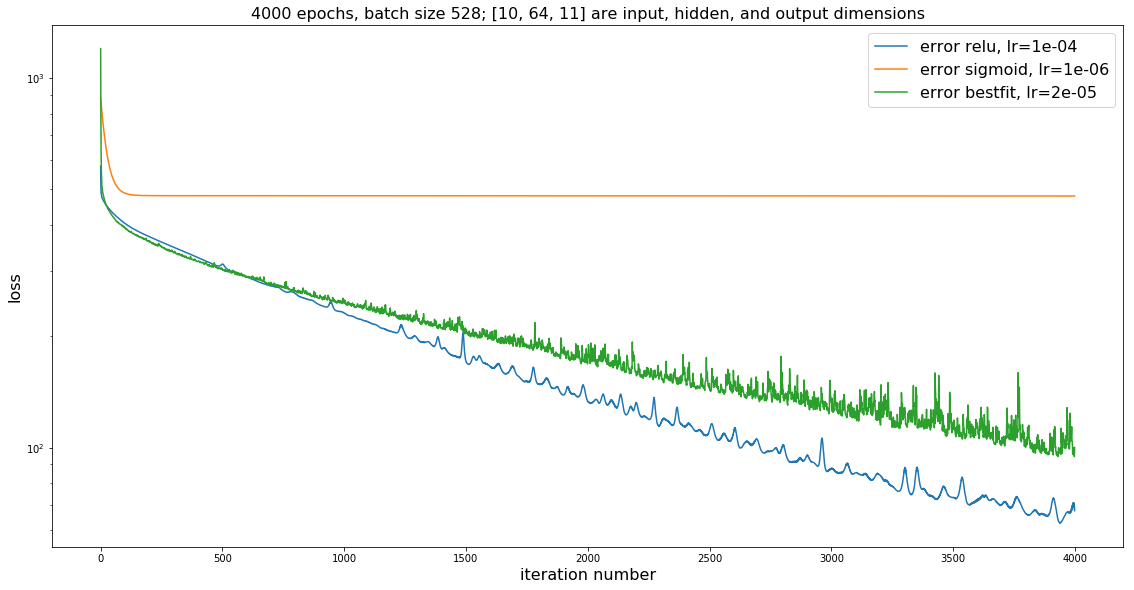

In [15]:
show_graph(show_type)

In [16]:
# testing results
correctness = 0
y_pred = basemodel(x_test)
for jj in range(x_test.shape[0]):
    if y_test.data[jj, np.argmax(y_pred.data[jj,:]) ]:
        correctness += 1
correctness = correctness/x_test.shape[0]*100
print(correctness)

y_pred = sigmodel(x_test)
for jj in range(x_test.shape[0]):
    if y_test.data[jj, np.argmax(y_pred.data[jj,:]) ]:
        correctness += 1
correctness = correctness/x_test.shape[0]*100
print(correctness)

y_pred = bestmodel(x_test)
for jj in range(x_test.shape[0]):
    if y_test.data[jj, np.argmax(y_pred.data[jj,:]) ]:
        correctness += 1
correctness = correctness/x_test.shape[0]*100
print(correctness)

52.81385281385281
21.171829613388052
54.58264710246495
